# The Battle of the Neighborhoods

Author : Guillaume RUE </br>
LinkedIn : https://www.linkedin.com/in/rueguillaume/

## 0. Introduction

The goal of this notebook is to segment Paris's neighborhoods into different clusters in order to predict which cluster of neighborhoods can be closer to the neighborhood of Manhattan : Murray Hill </br>
The cluster segmentation will be based on the venues of each neighborhood.

## 1. Libraries

In [4]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
!conda install -c conda-forge bs4 --yes 
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import folium # map rendering library

print("Libraries imported.")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         393 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

## 2. Data

### 2-1. Manhattan Upper East Side

The goal of this section is only to get the data we need of the neighborhood. All the code is taken from the IBM Lab "Segmenting and Clustering Neighborhoods in New York City" </br>
The dataset is free and can be find on this [link](https://geo.nyu.edu/catalog/nyu_2451_34572)

In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [7]:
#Extraction of Upper East Side Neighborhood
manhattan_data = manhattan_data[manhattan_data['Neighborhood'] == 'Murray Hill'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Murray Hill,40.748303,-73.978332


### 2-2. Paris

In this section I will use two free JSON datasets that you can download thanks to the following links : </br>
* [Paris's boroughs](https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e)
* [Paris's neighborhoods](https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=json&timezone=Europe/Berlin)

In [51]:
with open('correspondances-code-insee-code-postal.json') as json_data:
    paris_data = json.load(json_data)

If you want to see the JSON you can uncomment the following cell.

In [52]:
#paris_data

<strong>Exploration of the first dataset</strong>

In [53]:
df_idf = pd.read_json('correspondances-code-insee-code-postal.json')
df_idf.head()

,datasetid,recordid,fields,geometry,record_timestamp
0,correspondances-code-insee-code-postal,2bf36b38314b6c39dfbcd09225f97fa532b1fc45,"{'code_comm': '645', 'nom_dept': 'ESSONNE', 's...","{'type': 'Point', 'coordinates': [2.2517129721...",2016-09-21T00:29:06.175+02:00
1,correspondances-code-insee-code-postal,7ee82e74e059b443df18bb79fc5a19b1f05e5a88,"{'code_comm': '133', 'nom_dept': 'SEINE-ET-MAR...","{'type': 'Point', 'coordinates': [3.0529405055...",2016-09-21T00:29:06.175+02:00
2,correspondances-code-insee-code-postal,e2cd3186f07286705ed482a10b6aebd9de633c81,"{'code_comm': '378', 'nom_dept': 'ESSONNE', 's...","{'type': 'Point', 'coordinates': [2.1971816504...",2016-09-21T00:29:06.175+02:00
3,correspondances-code-insee-code-postal,868bf03527a1d0a9defe5cf4e6fa0a730d725699,"{'code_comm': '243', 'nom_dept': 'SEINE-ET-MAR...","{'type': 'Point', 'coordinates': [2.7097808131...",2016-09-21T00:29:06.175+02:00
4,correspondances-code-insee-code-postal,1bbcee92101fdb50f5f5fceb052681f2421ff961,"{'code_comm': '414', 'nom_dept': 'SEINE-ET-MAR...","{'type': 'Point', 'coordinates': [3.2582355268...",2016-09-21T00:29:06.175+02:00


Here we can see all the information we need is in the colum "field", so let's create a Dataframe for this column

In [54]:
df_idf_r = pd.DataFrame()
for m in df_idf.fields:
    dict_new = m
    df_idf_r = df_idf_r.append(dict_new, ignore_index=True)

df_idf_r.head()

,code_arr,code_cant,code_comm,code_dept,code_reg,geo_point_2d,geo_shape,id_geofla,insee_com,nom_comm,nom_dept,nom_region,population,postal_code,statut,superficie,z_moyen
0,3,03,645,91,11,"[48.750443119964764, 2.251712972144151]","{'type': 'Polygon', 'coordinates': [[[2.238024...",16275,91645,VERRIERES-LE-BUISSON,ESSONNE,ILE-DE-FRANCE,15.5,91370,Commune simple,999.0,121.0
1,3,20,133,77,11,"[48.41256065214989, 3.052940505560729]","{'type': 'Polygon', 'coordinates': [[[3.076046...",31428,77133,COURCELLES-EN-BASSEE,SEINE-ET-MARNE,ILE-DE-FRANCE,0.2,77126,Commune simple,1082.0,88.0
2,1,09,378,91,11,"[48.52726809075556, 2.19718165044305]","{'type': 'Polygon', 'coordinates': [[[2.203466...",30975,91378,MAUCHAMPS,ESSONNE,ILE-DE-FRANCE,0.3,91730,Commune simple,313.0,150.0
3,5,14,243,77,11,"[48.87307018579678, 2.7097808131278462]","{'type': 'Polygon', 'coordinates': [[[2.727542...",17000,77243,LAGNY-SUR-MARNE,SEINE-ET-MARNE,ILE-DE-FRANCE,20.2,77400,Chef-lieu canton,579.0,71.0
4,3,25,414,77,11,"[48.62891464105825, 3.2582355268439223]","{'type': 'Polygon', 'coordinates': [[[3.294591...",34949,77414,SAINT-HILLIERS,SEINE-ET-MARNE,ILE-DE-FRANCE,0.4,77160,Commune simple,1907.0,158.0


Here I decided to explore only Paris

In [55]:
df_paris = df_idf_r[df_idf_r["nom_dept"] == "PARIS"].reset_index(drop = True)
df_paris.head()

,code_arr,code_cant,code_comm,code_dept,code_reg,geo_point_2d,geo_shape,id_geofla,insee_com,nom_comm,nom_dept,nom_region,population,postal_code,statut,superficie,z_moyen
0,1,23,109,75,11,"[48.87689616237872, 2.337460241388529]","{'type': 'Polygon', 'coordinates': [[[2.325754...",16867,75109,PARIS-9E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,60.3,75009,Chef-lieu canton,218.0,44.0
1,1,24,110,75,11,"[48.87602855694339, 2.361112904561707]","{'type': 'Polygon', 'coordinates': [[[2.363856...",8429,75110,PARIS-10E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,95.9,75010,Chef-lieu canton,288.0,45.0
2,1,30,116,75,11,"[48.86039876035177, 2.262099559395783]","{'type': 'Polygon', 'coordinates': [[[2.262784...",36580,75116,PARIS-16E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,169.4,75016,Chef-lieu canton,1641.0,43.0
3,1,16,102,75,11,"[48.86790337886785, 2.344107166658533]","{'type': 'Polygon', 'coordinates': [[[2.350834...",14312,75102,PARIS-2E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,22.4,75002,Chef-lieu canton,99.0,36.0
4,1,25,111,75,11,"[48.85941549762748, 2.378741060237548]","{'type': 'Polygon', 'coordinates': [[[2.399114...",36586,75111,PARIS-11E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,152.7,75011,Chef-lieu canton,366.0,43.0


In [56]:
df_paris.sort_values(by = 'postal_code',axis = 0, ascending = True, inplace = True)
df_paris.head()

,code_arr,code_cant,code_comm,code_dept,code_reg,geo_point_2d,geo_shape,id_geofla,insee_com,nom_comm,nom_dept,nom_region,population,postal_code,statut,superficie,z_moyen
14,1,15,101,75,11,"[48.8626304851685, 2.336293446550539]","{'type': 'Polygon', 'coordinates': [[[2.344559...",36588,75101,PARIS-1ER-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,17.6,75001,Capitale d'état,181.0,33.0
3,1,16,102,75,11,"[48.86790337886785, 2.344107166658533]","{'type': 'Polygon', 'coordinates': [[[2.350834...",14312,75102,PARIS-2E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,22.4,75002,Chef-lieu canton,99.0,36.0
7,1,17,103,75,11,"[48.86305413181178, 2.359361058970589]","{'type': 'Polygon', 'coordinates': [[[2.368401...",36582,75103,PARIS-3E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,35.7,75003,Chef-lieu canton,116.0,35.0
17,1,18,104,75,11,"[48.854228281954754, 2.357361938142205]","{'type': 'Polygon', 'coordinates': [[[2.364320...",11667,75104,PARIS-4E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,28.2,75004,Chef-lieu canton,160.0,33.0
15,1,19,105,75,11,"[48.844508659617546, 2.349859385560182]","{'type': 'Polygon', 'coordinates': [[[2.365944...",13706,75105,PARIS-5E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,61.5,75005,Chef-lieu canton,252.0,42.0


So, let's take only the columns that are relevant for this project :
* nom_comm : name of the borough
* postal_code : postal code of the borough
* population : number of habitants per 1000
* geo_point_2d : latitude and longitude of the borough 

In [57]:
df_paris = df_paris[['nom_comm','postal_code','population','geo_point_2d']].reset_index(drop = True)

df_paris = df_paris.rename(columns = {"nom_comm":"num_arr"})
df_paris.head()

,num_arr,postal_code,population,geo_point_2d
0,PARIS-1ER-ARRONDISSEMENT,75001,17.6,"[48.8626304851685, 2.336293446550539]"
1,PARIS-2E-ARRONDISSEMENT,75002,22.4,"[48.86790337886785, 2.344107166658533]"
2,PARIS-3E-ARRONDISSEMENT,75003,35.7,"[48.86305413181178, 2.359361058970589]"
3,PARIS-4E-ARRONDISSEMENT,75004,28.2,"[48.854228281954754, 2.357361938142205]"
4,PARIS-5E-ARRONDISSEMENT,75005,61.5,"[48.844508659617546, 2.349859385560182]"


In [58]:
# Transform label of each borough by number of borough
df_paris.loc[0:8,'num_arr'] = df_paris.loc[0:8,"num_arr"].str[6:7].astype(int)
df_paris.loc[9:,'num_arr'] = df_paris.loc[9:,"num_arr"].str[6:8].astype(int)

In [59]:
df_paris

,num_arr,postal_code,population,geo_point_2d
0,1,75001,17.6,"[48.8626304851685, 2.336293446550539]"
1,2,75002,22.4,"[48.86790337886785, 2.344107166658533]"
2,3,75003,35.7,"[48.86305413181178, 2.359361058970589]"
3,4,75004,28.2,"[48.854228281954754, 2.357361938142205]"
4,5,75005,61.5,"[48.844508659617546, 2.349859385560182]"
5,6,75006,43.1,"[48.84896809191946, 2.332670898588416]"
6,7,75007,57.4,"[48.85608259819694, 2.312438687733857]"
7,8,75008,40.3,"[48.87252726662346, 2.312582560420059]"
8,9,75009,60.3,"[48.87689616237872, 2.337460241388529]"
9,10,75010,95.9,"[48.87602855694339, 2.361112904561707]"


### 2-2. Visualisation of the data

Now we can easily create a map of Paris and point each borough to have a first look

In [60]:
address = 'PARIS ,PAR'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8418339, 2.3497835.


In [61]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for [lat, lng], postcode, borough, population in zip(df_paris['geo_point_2d'], df_paris['postal_code'],df_paris['num_arr'], df_paris['population']):
    label = 'Arrondissement {}, population: {}'.format(borough, population*1000)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

### 2-3 Exploration of the second dataset

This dataset allows us to find neighborhoods for each borough of Paris.

In [62]:
# Extract neighborhoods in city of Paris
df_Q = pd.read_json('quartier_paris.json')

df_quartier = pd.DataFrame()

for q in df_Q.fields:
    dict_new = q
    df_quartier = df_quartier.append(dict_new, ignore_index=True)
    
df_quartier = df_quartier.rename(columns = {"c_ar":"num_arr","c_qu":"num_neighborhood","c_quinsee":"num_insee_quartier","l_qu":"neighborhood"})

convert_dict = {'num_arr': int}

df_quartier = df_quartier.astype(convert_dict)

df_quartier.head()

,num_arr,num_neighborhood,num_insee_quartier,geom,geom_x_y,neighborhood,n_sq_ar,n_sq_qu,perimetre,surface
0,6,23.0,7510603.0,"{'type': 'Polygon', 'coordinates': [[[2.336756...","[48.846427594, 2.32735687823]",Notre-Dame-des-Champs,750000006.0,750000023.0,4559.989773,8.613070e+05
1,14,55.0,7511403.0,"{'type': 'Polygon', 'coordinates': [[[2.329136...","[48.8266526255, 2.32643699922]",Petit-Montrouge,750000014.0,750000055.0,5490.636672,1.345774e+06
2,19,74.0,7511902.0,"{'type': 'Polygon', 'coordinates': [[[2.384878...","[48.8955557746, 2.38477722927]",Pont-de-Flandre,750000019.0,750000074.0,6397.871676,2.376238e+06
3,16,62.0,7511602.0,"{'type': 'Polygon', 'coordinates': [[[2.245624...","[48.8632745438, 2.2599358317]",Muette,750000016.0,750000062.0,11962.438594,5.477898e+06
4,16,64.0,7511604.0,"{'type': 'Polygon', 'coordinates': [[[2.292681...","[48.8684336145, 2.2916790427400002]",Chaillot,750000016.0,750000064.0,5207.046446,1.424035e+06


In [64]:
df_borough = df_paris[['num_arr','postal_code','population']].reset_index(drop = True)
df_quartier = df_quartier[['num_arr','num_neighborhood','neighborhood','geom_x_y']].reset_index(drop = True)

In [65]:
df_quartier = df_quartier.join(df_borough.set_index('num_arr'), on='num_arr')

df_quartier.head()

,num_arr,num_neighborhood,neighborhood,geom_x_y,postal_code,population
0,6,23.0,Notre-Dame-des-Champs,"[48.846427594, 2.32735687823]",75006,43.1
1,14,55.0,Petit-Montrouge,"[48.8266526255, 2.32643699922]",75014,137.2
2,19,74.0,Pont-de-Flandre,"[48.8955557746, 2.38477722927]",75019,184.8
3,16,62.0,Muette,"[48.8632745438, 2.2599358317]",75016,169.4
4,16,64.0,Chaillot,"[48.8684336145, 2.2916790427400002]",75016,169.4


Let's check is we have null values

In [66]:
df_quartier.isna().sum()

num_arr             0
num_neighborhood    0
neighborhood        0
geom_x_y            0
postal_code         0
population          0
dtype: int64

In [67]:
#Size of the final dataframe
df_quartier.shape

(80, 6)

In [69]:
df_quartier.sort_values(by = 'num_neighborhood',axis = 0, ascending = True, inplace = True)
df_quartier = df_quartier[['num_arr','num_neighborhood','neighborhood','postal_code','geom_x_y']].reset_index(drop = True)
df_quartier.head(7)

,num_arr,num_neighborhood,neighborhood,postal_code,geom_x_y
0,1,1.0,Saint-Germain-l'Auxerrois,75001,"[48.8606501352, 2.33491032928]"
1,1,2.0,Halles,75001,"[48.8622891081, 2.34489885831]"
2,1,3.0,Palais-Royal,75001,"[48.8646599781, 2.33630891897]"
3,1,4.0,Place-Vendôme,75001,"[48.8670185906, 2.3285816649299997]"
4,2,5.0,Gaillon,75002,"[48.8693066381, 2.33343180766]"
5,2,6.0,Vivienne,75002,"[48.8691001998, 2.33946074375]"
6,2,7.0,Mail,75002,"[48.8680083374, 2.34469912743]"


### 2-4. Visualisation of the the neighborhoods

In [70]:
address = 'PARIS ,PAR'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Paris are 48.8418339, 2.3497835.


In [71]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for [lat, lng], postcode, borough, neighborhood in zip(df_quartier['geom_x_y'], df_quartier['postal_code'],df_quartier['num_arr'], df_quartier['neighborhood']):
    label = '{}, Arrondissement: {}, Postal code: {}'.format(neighborhood, borough, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

## 3. Foursquare API

In [72]:
#Credentials for the API
CLIENT_ID = 'YJANUI0ZZ00OH301GOKDJPFGLI4LVRR1FSXUNPJRP4NUBFJR' # your Foursquare ID
CLIENT_SECRET = '0XKKMIZFKUHKKJEJD4QV4XINTI0P2LOKHYWBOGDKHLCDU452' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: YJANUI0ZZ00OH301GOKDJPFGLI4LVRR1FSXUNPJRP4NUBFJR
CLIENT_SECRET:0XKKMIZFKUHKKJEJD4QV4XINTI0P2LOKHYWBOGDKHLCDU452


### 3-1. Explore Foursquare data of Murray Hill

Now that the datasets are ready, let's take a look at the Manhattan's neighborhood to see what are the venues we should find in Paris.

In [73]:
# Get neighborhood latitude and longitude
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, neighborhood_latitude, neighborhood_longitude))

Latitude and longitude values of Murray Hill are 40.748303077252174, -73.97833207924127.


Now let's get the top 100 venues of Murray Hill

In [74]:
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=YJANUI0ZZ00OH301GOKDJPFGLI4LVRR1FSXUNPJRP4NUBFJR&client_secret=0XKKMIZFKUHKKJEJD4QV4XINTI0P2LOKHYWBOGDKHLCDU452&ll=40.748303077252174,-73.97833207924127&v=20180605&radius=500&limit=100'

In [75]:
results = requests.get(url).json()
#results

In [76]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

This function was created earlier, when the IBM course was about Foursquare API </br>
Now, let's structure json into a pandas dataframe

In [77]:
#Code from IBM course
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,Ippodo Tea Co.,Tea Room,40.749757,-73.977733
1,Kajitsu,Japanese Restaurant,40.749763,-73.977688
2,Sons of Thunder,Hawaiian Restaurant,40.747970,-73.975751
3,Perk Kafe,Coffee Shop,40.747768,-73.977363
4,"The Renwick Hotel, Curio Collection by Hilton",Hotel,40.750184,-73.977604


In [78]:
nearby_venues.groupby('categories').count()

,name,lat,lng
categories,,,
American Restaurant,3,3,3
Bagel Shop,2,2,2
Bakery,1,1,1
Bar,2,2,2
Boxing Gym,1,1,1
Building,1,1,1
Burger Joint,2,2,2
Café,2,2,2
Cheese Shop,1,1,1


Most of the venues are restaurants/fast foods, so we can suppose a similar neighborhood in Paris should also have many restaurants.</br>
We can also see, if we don't group all restaurants, hotels and coffee shops are mostly present in Murray Hill.

## 4. Analyze Foursquare data

Let's create a function to repeat the same process to all the neighborhoods in Paris

In [79]:
#Code drom IBM course
def getNearbyVenues(names, geom_x_y, radius=500):
    
    venues_list=[]
    for name, [lat, lng] in zip(names, geom_x_y):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In order to prepare the clustering, I decided to get Paris's neighborhoods and Murray Hill in the same variable. By doing this I can easily prepare my data for the following cells and have the same venues categories for all the neighborhoods.

In [80]:
names = df_quartier['neighborhood']
names = names.append(pd.Series(['Murray Hill']),ignore_index = True)

coordinates = df_quartier['geom_x_y']
coordinates = coordinates.append(pd.Series([[manhattan_data.iloc[0]['Latitude'],manhattan_data.iloc[0]['Longitude']]]),ignore_index = True)

Now let's create a dataframe called data_venues on each neighborhood

In [81]:
data_venues = getNearbyVenues(names=names,
                                   geom_x_y=coordinates
                                  )

Saint-Germain-l'Auxerrois
Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoie
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Invalides
Ecole-Militaire
Gros-Caillou
Champs-Elysées
Faubourg-du-Roule
Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc-de-Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
Muette
Porte-Dauphine
Chaillot
Ternes
Plaine de Monceaux
Batignolles
Epinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
Villette
Pont-de-Flandre
Amérique
Combat
Belleville
Saint-Fargeau


Check number of venues per neighborhood

In [82]:
data_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Amérique,13,13,13,13,13,13
Archives,100,100,100,100,100,100
Arsenal,66,66,66,66,66,66
Arts-et-Métiers,100,100,100,100,100,100
Auteuil,18,18,18,18,18,18
Batignolles,100,100,100,100,100,100
Bel-Air,6,6,6,6,6,6
Belleville,42,42,42,42,42,42
Bercy,68,68,68,68,68,68


In [83]:
#Number of uniques categories
print('There are {} uniques categories.'.format(len(data_venues['Venue Category'].unique())))

There are 298 uniques categories.


In [84]:
# one hot encoding
data_onehot = pd.get_dummies(data_venues[['Venue Category']], prefix="", prefix_sep="")

#column lists before adding neighborhood
column_names = ['Neighborhood'] + list(data_onehot.columns)

# add neighborhood column back to dataframe
data_onehot['Neighborhood'] = data_venues['Neighborhood'] 

# move neighborhood column to the first column
data_onehot = data_onehot[column_names]

data_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Spot,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas R

In [85]:
data_grouped = data_onehot.groupby('Neighborhood').mean().reset_index()
data_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Spot,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas R

Let's see the top 5 venues of each neighborhood

In [86]:
num_top_venues = 5

for hood in data_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = data_grouped[data_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amérique----
               venue  freq
0        Supermarket  0.15
1  French Restaurant  0.15
2             Bistro  0.15
3  Health Food Store  0.08
4              Plaza  0.08


----Archives----
                 venue  freq
0    French Restaurant  0.10
1                Hotel  0.05
2  Japanese Restaurant  0.04
3                  Bar  0.04
4          Coffee Shop  0.04


----Arsenal----
               venue  freq
0  French Restaurant  0.17
1              Hotel  0.08
2              Plaza  0.05
3               Park  0.05
4      Boat or Ferry  0.03


----Arts-et-Métiers----
                venue  freq
0   French Restaurant  0.10
1               Hotel  0.06
2  Italian Restaurant  0.05
3                 Bar  0.05
4          Restaurant  0.04


----Auteuil----
                   venue  freq
0           Tennis Court  0.28
1                Stadium  0.17
2                 Garden  0.11
3                 Museum  0.06
4  Outdoors & Recreation  0.06


----Batignolles----
                venue  freq


For Murray Hill, the top 5 venues are coffee shops, sandwich places, hotels, japanese restaurants and pizza places so we can suppose we will find again most of them in the associated cluster

In [87]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [141]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = data_grouped['Neighborhood']

for ind in np.arange(data_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(data_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,French Restaurant,Supermarket,Bistro,Health Food Store,Café,Bed & Breakfast,Tram Station,Park,Pool,Plaza
1,Archives,French Restaurant,Hotel,Italian Restaurant,Japanese Restaurant,Coffee Shop,Clothing Store,Bookstore,Bistro,Bar,Plaza
2,Arsenal,French Restaurant,Hotel,Park,Plaza,Italian Restaurant,Thai Restaurant,Cocktail Bar,Seafood Restaurant,Boat or Ferry,Gastropub
3,Arts-et-Métiers,French Restaurant,Hotel,Italian Restaurant,Bar,Chinese Restaurant,Restaurant,Cocktail Bar,Wine Bar,Coffee Shop,Moroccan Restaurant
4,Auteuil,Tennis Court,Stadium,Garden,Botanical Garden,Office,Outdoors & Recreation,Bike Rental / Bike Share,Racecourse,Museum,French Restaurant
5,Batignolles,French Restaurant,Hotel,Italian Restaurant,Bar,Bistro,Café,Japanese Restaurant,Restaurant,Chinese Restaurant,Park
6,Bel-Air,Sports Club,French Restaurant,Recreation Center,Plaza,Playground,Café,Farmers Market,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
7,Belleville,Bar,French Restaurant,Japanese Restaurant,Italian Restaurant,Bistro,Music Venue,Beer Store,Restaurant,Gourmet Shop,Chinese Restaurant
8,Bercy,Hotel,French Restaurant,Bar,Italian Restaurant,Café,Bakery,Museum,Supermarket,Wine Bar,Breakfast Spot
9,Bonne-Nouvelle,French Restaurant,Cocktail Bar,Hotel,Bakery,Coffee Shop,Wine Bar,Italian Restaurant,Bar,Chinese Restaurant,Pastry Shop


## 5. Cluster Neighborhood

First, let's move Murray Hill to another df

In [89]:
murray_grouped = data_grouped[data_grouped['Neighborhood'] == 'Murray Hill'].reset_index(drop=True)


delete_row = data_grouped[data_grouped["Neighborhood"]=='Murray Hill'].index
data_grouped = data_grouped.drop(delete_row)

First we need to determine the value of k

In [90]:
paris_grouped_clustering = data_grouped.drop('Neighborhood', 1)

### 5-1. The Elbow Method

In [91]:
kmax = range(1,20)
sum_of_squared_dis = []
for k in kmax:
    print(k)
    kmeans = KMeans(n_clusters=k).fit(paris_grouped_clustering)
    sum_of_squared_dis.append(kmeans.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, 'Elbow method')

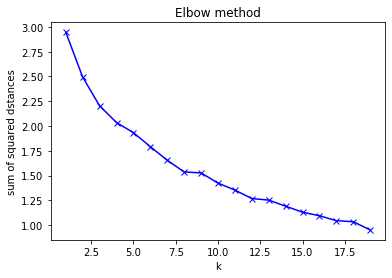

In [92]:
plt.plot(kmax,sum_of_squared_dis, 'bx-')
plt.xlabel("k")
plt.ylabel("sum of squared dstances")
plt.title("Elbow method")

In this case the method is not the best one to determine k, so let's use the silhouette method to have a second opinion

### 5-2. The Silhouette method

In this method k can't be equal to 1, we must start with k = 2

In [137]:
sil = []
K_sil = range(2,20)
for k in K_sil:
    print(k)
    kmeans = KMeans(n_clusters=k).fit(paris_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(paris_grouped_clustering, labels, metric = 'euclidean'))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, 'silhouette method')

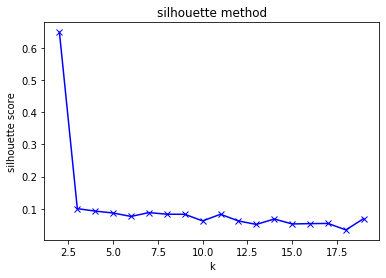

In [138]:
plt.plot(K_sil,sil, 'bx-')
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.title("silhouette method")

Here we can't really see where there are peaks, and we can assume we won't take k=2, it's not wide enough, so let's plot the same graph and starting with k=3

Text(0.5, 1.0, 'silhouette method')

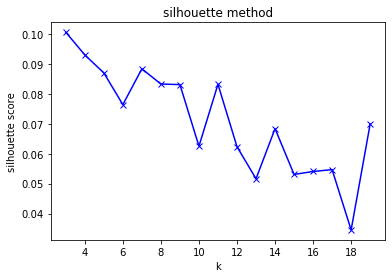

In [139]:
sil.pop(0)
K_sil = range(3,20)
plt.plot(K_sil,sil, 'bx-')
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.title("silhouette method")

So we have a peak at k=7 and k=10, I decided to choose k=6

In [140]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(init='k-means++',n_clusters=kclusters, n_init=20).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 4, 2, 5, 4, 6, 2, 2, 2], dtype=int32)

In [142]:
delete_row = neighborhoods_venues_sorted[neighborhoods_venues_sorted["Neighborhood"]=='Murray Hill'].index
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop(delete_row)

In [143]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()
paris_merged = df_quartier
#df_quartier.head()
# merge paris_grouped with paris to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')

paris_merged.head() # check the last columns!

,num_arr,num_neighborhood,neighborhood,postal_code,geom_x_y,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,1.0,Saint-Germain-l'Auxerrois,75001,"[48.8606501352, 2.33491032928]",4,French Restaurant,Hotel,Coffee Shop,Plaza,Art Museum,Historic Site,Cosmetics Shop,Café,Bar,Italian Restaurant
1,1,2.0,Halles,75001,"[48.8622891081, 2.34489885831]",2,French Restaurant,Coffee Shop,Ice Cream Shop,Bakery,Chinese Restaurant,Spa,Pub,Thai Restaurant,Bar,Plaza
2,1,3.0,Palais-Royal,75001,"[48.8646599781, 2.33630891897]",2,Japanese Restaurant,French Restaurant,Hotel,Coffee Shop,Plaza,Italian Restaurant,Café,Wine Bar,Historic Site,Bookstore
3,1,4.0,Place-Vendôme,75001,"[48.8670185906, 2.3285816649299997]",1,Hotel,French Restaurant,Jewelry Store,Japanese Restaurant,Chocolate Shop,Dessert Shop,Plaza,Bookstore,Boutique,Hotel Bar
4,2,5.0,Gaillon,75002,"[48.8693066381, 2.33343180766]",2,Japanese Restaurant,Hotel,French Restaurant,Wine Bar,Jewelry Store,Italian Restaurant,Bakery,Bookstore,Restaurant,Chocolate Shop


In [144]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for [lat, lon], poi, cluster in zip(paris_merged['geom_x_y'], paris_merged['neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [145]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,num_neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,49.0,0,Indian Restaurant,French Restaurant,Supermarket,Mediterranean Restaurant,Bar,Gym / Fitness Center,Cajun / Creole Restaurant,Chinese Restaurant,Sushi Restaurant,Pet Store
62,63.0,0,Tennis Court,Park,Plaza,Grocery Store,Pizza Place,Gym / Fitness Center,Soccer Field,Supermarket,Metro Station,Gym Pool
70,71.0,0,Bar,Fast Food Restaurant,Supermarket,Chinese Restaurant,Asian Restaurant,Convenience Store,Coffee Shop,Café,Pizza Place,Mediterranean Restaurant
71,72.0,0,Soccer Field,Supermarket,Chinese Restaurant,Thai Restaurant,Asian Restaurant,Farmers Market,Vietnamese Restaurant,Mexican Restaurant,Garden,French Restaurant
73,74.0,0,Hotel,Supermarket,French Restaurant,Asian Restaurant,Café,Movie Theater,Rock Club,Tram Station,Restaurant,Cocktail Bar
74,75.0,0,French Restaurant,Supermarket,Bistro,Health Food Store,Café,Bed & Breakfast,Tram Station,Park,Pool,Plaza
77,78.0,0,Plaza,Supermarket,Café,Pool,Arts & Entertainment,French Restaurant,Gas Station,Bar,Bakery,Diner
79,80.0,0,Supermarket,Hotel,Café,Bar,Tram Station,Grocery Store,French Restaurant,Bike Rental / Bike Share,Bistro,Music Venue


In [146]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,num_neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,4.0,1,Hotel,French Restaurant,Jewelry Store,Japanese Restaurant,Chocolate Shop,Dessert Shop,Plaza,Bookstore,Boutique,Hotel Bar
26,27.0,1,Hotel,French Restaurant,Plaza,Dessert Shop,Garden,Café,Bistro,Farmers Market,Diner,Asian Restaurant
29,30.0,1,French Restaurant,Hotel,Jewelry Store,Cosmetics Shop,Café,Tailor Shop,Asian Restaurant,Japanese Restaurant,Men's Store,Electronics Store
30,31.0,1,Hotel,French Restaurant,Boutique,Women's Store,Gourmet Shop,Theater,Dessert Shop,Clothing Store,Italian Restaurant,Hotel Bar
32,33.0,1,Hotel,French Restaurant,Cocktail Bar,Italian Restaurant,Bistro,Café,Lounge,Sushi Restaurant,Plaza,American Restaurant
35,36.0,1,French Restaurant,Hotel,Bakery,Bar,Vegetarian / Vegan Restaurant,Pizza Place,Italian Restaurant,Restaurant,Coffee Shop,Park
54,55.0,1,Hotel,French Restaurant,Italian Restaurant,Supermarket,Bakery,Japanese Restaurant,Sushi Restaurant,Food & Drink Shop,Fast Food Restaurant,Bistro
55,56.0,1,Hotel,French Restaurant,Bistro,Japanese Restaurant,Café,Bar,Grocery Store,Bakery,Gym,Beer Store
57,58.0,1,Hotel,French Restaurant,Café,Korean Restaurant,Gym / Fitness Center,Bakery,Dessert Shop,Italian Restaurant,Pharmacy,Brasserie
58,59.0,1,Hotel,French Restaurant,Japanese Restaurant,Bakery,Bistro,Italian Restaurant,Gym / Fitness Center,Cheese Shop,Coffee Shop,Salon / Barbershop


In [147]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,num_neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,2.0,2,French Restaurant,Coffee Shop,Ice Cream Shop,Bakery,Chinese Restaurant,Spa,Pub,Thai Restaurant,Bar,Plaza
2,3.0,2,Japanese Restaurant,French Restaurant,Hotel,Coffee Shop,Plaza,Italian Restaurant,Café,Wine Bar,Historic Site,Bookstore
4,5.0,2,Japanese Restaurant,Hotel,French Restaurant,Wine Bar,Jewelry Store,Italian Restaurant,Bakery,Bookstore,Restaurant,Chocolate Shop
5,6.0,2,Japanese Restaurant,French Restaurant,Wine Bar,Hotel,Bistro,Coffee Shop,Clothing Store,Salad Place,Bakery,Bookstore
6,7.0,2,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Coffee Shop,Italian Restaurant,Salad Place,Bar,Hotel,Japanese Restaurant
7,8.0,2,French Restaurant,Cocktail Bar,Hotel,Bakery,Coffee Shop,Wine Bar,Italian Restaurant,Bar,Chinese Restaurant,Pastry Shop
8,9.0,2,French Restaurant,Hotel,Italian Restaurant,Bar,Chinese Restaurant,Restaurant,Cocktail Bar,Wine Bar,Coffee Shop,Moroccan Restaurant
9,10.0,2,French Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Wine Bar,Restaurant,Art Gallery,Creperie,Sandwich Place,Café
10,11.0,2,French Restaurant,Hotel,Italian Restaurant,Japanese Restaurant,Coffee Shop,Clothing Store,Bookstore,Bistro,Bar,Plaza
11,12.0,2,French Restaurant,Art Gallery,Hotel,Café,Chinese Restaurant,Burger Joint,Restaurant,Coffee Shop,Bakery,Italian Restaurant


In [148]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,num_neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,46.0,3,Locksmith,Hotel,Fish & Chips Shop,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant


In [149]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,num_neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1.0,4,French Restaurant,Hotel,Coffee Shop,Plaza,Art Museum,Historic Site,Cosmetics Shop,Café,Bar,Italian Restaurant
14,15.0,4,French Restaurant,Hotel,Park,Plaza,Italian Restaurant,Thai Restaurant,Cocktail Bar,Seafood Restaurant,Boat or Ferry,Gastropub
15,16.0,4,French Restaurant,Italian Restaurant,Japanese Restaurant,Plaza,Bakery,Ice Cream Shop,Wine Bar,Hotel,Tapas Restaurant,Coffee Shop
16,17.0,4,French Restaurant,Hotel,Bakery,Bar,Italian Restaurant,Pub,Wine Bar,Plaza,Bistro,Park
17,18.0,4,French Restaurant,Hotel,Science Museum,Garden,Zoo Exhibit,Tea Room,Botanical Garden,Greek Restaurant,Moroccan Restaurant,Museum
22,23.0,4,French Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bistro,Creperie,Steakhouse,Tea Room,Café
23,24.0,4,French Restaurant,Hotel,Italian Restaurant,Café,Plaza,Wine Bar,Japanese Restaurant,Sandwich Place,Clothing Store,Pastry Shop
24,25.0,4,French Restaurant,Hotel,Italian Restaurant,Café,Coffee Shop,Bookstore,Sandwich Place,Cheese Shop,Bakery,Bistro
25,26.0,4,French Restaurant,Plaza,Café,Hotel,History Museum,Art Museum,Park,Italian Restaurant,Cultural Center,Japanese Restaurant
27,28.0,4,French Restaurant,Italian Restaurant,Hotel,Café,Bakery,Coffee Shop,Bistro,Ice Cream Shop,Dessert Shop,Cheese Shop


In [150]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,num_neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,61.0,5,Tennis Court,Stadium,Garden,Botanical Garden,Office,Outdoors & Recreation,Bike Rental / Bike Share,Racecourse,Museum,French Restaurant


In [151]:
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,num_neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,45.0,6,Sports Club,French Restaurant,Recreation Center,Plaza,Playground,Café,Farmers Market,Empanada Restaurant,English Restaurant,Ethiopian Restaurant


## 6. Predict cluster of Murray Hill

In [152]:
murray_grouped_clustering = murray_grouped.drop('Neighborhood', 1)

In [158]:
print('Cluster number {} '.format(kmeans.predict(murray_grouped_clustering)[0]))

Cluster number 2 


In [163]:
cluster = paris_merged.loc[paris_merged['Cluster Labels'] == kmeans.predict(murray_grouped_clustering)[0], paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]
cluster.head()

,num_neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,2.0,2,French Restaurant,Coffee Shop,Ice Cream Shop,Bakery,Chinese Restaurant,Spa,Pub,Thai Restaurant,Bar,Plaza
2,3.0,2,Japanese Restaurant,French Restaurant,Hotel,Coffee Shop,Plaza,Italian Restaurant,Café,Wine Bar,Historic Site,Bookstore
4,5.0,2,Japanese Restaurant,Hotel,French Restaurant,Wine Bar,Jewelry Store,Italian Restaurant,Bakery,Bookstore,Restaurant,Chocolate Shop
5,6.0,2,Japanese Restaurant,French Restaurant,Wine Bar,Hotel,Bistro,Coffee Shop,Clothing Store,Salad Place,Bakery,Bookstore
6,7.0,2,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Coffee Shop,Italian Restaurant,Salad Place,Bar,Hotel,Japanese Restaurant


In [164]:
cluster = cluster.merge(df_quartier, on='num_neighborhood', how='left')
cluster

,num_neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,num_arr,neighborhood,postal_code,geom_x_y
0,2.0,2,French Restaurant,Coffee Shop,Ice Cream Shop,Bakery,Chinese Restaurant,Spa,Pub,Thai Restaurant,Bar,Plaza,1,Halles,75001,"[48.8622891081, 2.34489885831]"
1,3.0,2,Japanese Restaurant,French Restaurant,Hotel,Coffee Shop,Plaza,Italian Restaurant,Café,Wine Bar,Historic Site,Bookstore,1,Palais-Royal,75001,"[48.8646599781, 2.33630891897]"
2,5.0,2,Japanese Restaurant,Hotel,French Restaurant,Wine Bar,Jewelry Store,Italian Restaurant,Bakery,Bookstore,Restaurant,Chocolate Shop,2,Gaillon,75002,"[48.8693066381, 2.33343180766]"
3,6.0,2,Japanese Restaurant,French Restaurant,Wine Bar,Hotel,Bistro,Coffee Shop,Clothing Store,Salad Place,Bakery,Bookstore,2,Vivienne,75002,"[48.8691001998, 2.33946074375]"
4,7.0,2,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Coffee Shop,Italian Restaurant,Salad Place,Bar,Hotel,Japanese Restaurant,2,Mail,75002,"[48.8680083374, 2.34469912743]"
5,8.0,2,French Restaurant,Cocktail Bar,Hotel,Bakery,Coffee Shop,Wine Bar,Italian Restaurant,Bar,Chinese Restaurant,Pastry Shop,2,Bonne-Nouvelle,75002,"[48.8671501183, 2.35008019041]"
6,9.0,2,French Restaurant,Hotel,Italian Restaurant,Bar,Chinese Restaurant,Restaurant,Cocktail Bar,Wine Bar,Coffee Shop,Moroccan Restaurant,3,Arts-et-Métiers,75003,"[48.8664702895, 2.35708313106]"
7,10.0,2,French Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Wine Bar,Restaurant,Art Gallery,Creperie,Sandwich Place,Café,3,Enfants-Rouges,75003,"[48.863887392, 2.36312330099]"
8,11.0,2,French Restaurant,Hotel,Italian Restaurant,Japanese Restaurant,Coffee Shop,Clothing Store,Bookstore,Bistro,Bar,Plaza,3,Archives,75003,"[48.8591924127, 2.36320505733]"
9,12.0,2,French Restaurant,Art Gallery,Hotel,Café,Chinese Restaurant,Burger Joint,Restaurant,Coffee Shop,Bakery,Italian Restaurant,3,Sainte-Avoie,75003,"[48.862557245, 2.35485151825]"


As we supposed earlier, we can see some of the most common venues are coffee shops, hotels, japanese restaurant, so we can say Murray Hill has been pretty well associated

In [166]:
cluster.groupby('num_arr').count()['num_neighborhood']

num_arr
1     2
2     4
3     4
4     2
5     2
6     2
10    3
11    3
12    2
13    2
14    1
17    1
18    1
19    1
20    2
Name: num_neighborhood, dtype: int64

Finally, Murray Hills has similar neighborhoods in many boroughs of Paris, but many of them are in the 2nd and 3rd borough. So we can conclude a person who needs to move from Murray Hill to Paris could try to find a place in one of this borough first (by only taking venues as references). 